In [1]:
import numpy as np
import pandas as pd
from six import StringIO
import pydotplus
from sklearn import tree
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier 

def draw_tree(model,name,feature_names):    
    dot_data = StringIO()    
    tree.export_graphviz(model, out_file = dot_data,
                         feature_names=feature_names,
                         filled=True, rounded=True,  
                         special_characters=True)    
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())    
    graph.write_pdf(name + ".pdf") 
    
def get_code_1(tree, feature_names):
        
        res_dict ={}
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node,rule_list=[]):
                
                if (threshold[node] != -2):
                        rule_list.append(features[node] + " <= " + str(round(threshold[node],2)))
                        if left[node] != -1:
                                recurse(left, right, threshold, features,left[node],rule_list)
                                
                        rule_list.remove(features[node] + " <= " + str(round(threshold[node],2)))
                        rule_list.append(features[node] + " > " + str(round(threshold[node],2)))
                        
                        if right[node] != -1:
                                recurse(left, right, threshold, features,right[node],rule_list)
                                
                        rule_list.remove(features[node] + " > " + str(round(threshold[node],2)))
                else:
                        rule_tuple = tuple(rule_list)
                        
                        sample = value[node][0][0]+value[node][0][1]+value[node][0][2]
                        yuqichufa = round(value[node][0][0]/(value[node][0][0]+value[node][0][1]+value[node][0][2]),4)
                        res_dict[rule_tuple] = [sample,yuqichufa]
                               

        
        rule_list = []
        recurse(left, right, threshold, features, 0,rule_list)
        return res_dict
    
def exec_rule(data,rules,y='perf'):
    data_after_ruler=data
    for rule in rules:
        if rule.split(' ')[1] == '<=':
            data_after_ruler=data_after_ruler[data_after_ruler[rule.split(' ')[0]] <= float(rule.split(' ')[2])]
        elif rule.split(' ')[1] == '>':
            data_after_ruler=data_after_ruler[data_after_ruler[rule.split(' ')[0]] > float(rule.split(' ')[2])]
            
    if data_after_ruler[data_after_ruler[y]==0].shape[0] == 0:
        return (data_after_ruler.shape[0],0)
    else:
        return (data_after_ruler.shape[0],round(data_after_ruler[data_after_ruler[y]==0].shape[0]/data_after_ruler.shape[0],4))

def ruler_valid(data_valid,train_res_dict,y='perf'):
    res_dict= train_res_dict
    for i in res_dict.keys():
        res_dict[i].append(exec_rule(data_valid,i,y=y)[0])
        res_dict[i].append(exec_rule(data_valid,i,y=y)[1])
    return res_dict

def main_process(DF_train,DF_test,columns = [],y='perf',criterion='gini',max_depth=4,splitter='best',min_samples_leaf=2,random_state=1110):
    
    estimator = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,splitter=splitter,min_samples_leaf=min_samples_leaf,random_state=random_state)
    estimator.fit(DF_train[columns], DF_train[y])
    res_dict = get_code_1(estimator, columns)
    res_dict_all  = ruler_valid(DF_test,res_dict,y=y)
    
    res_all_DF = pd.DataFrame.from_dict(res_dict_all,orient='index')
    res_all_DF.rename(columns={0:'train_ruler_sample',1:'train_ovd_rate',2:'valid_ruler_sample',3:'valid_ovd_rate'},inplace = True)
    res_all_DF['train_ruler_hit_rate'] = res_all_DF['train_ruler_sample']/res_all_DF['train_ruler_sample'].sum()
    res_all_DF['valid_ruler_hit_rate'] = res_all_DF['valid_ruler_sample']/res_all_DF['valid_ruler_sample'].sum()
    res_all_DF=res_all_DF.applymap(lambda x:round(x,4))
    res_all_DF = res_all_DF.reindex(columns=['train_ruler_sample','train_ruler_hit_rate','train_ovd_rate','valid_ruler_sample','valid_ruler_hit_rate','valid_ovd_rate'])
    aa = res_all_DF.sort_values(by=['valid_ovd_rate'],ascending=False)
    return aa,estimator

In [2]:
iris = load_iris()    
X = iris.data    
y = iris.target    
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)  

DF_X_train = pd.DataFrame(X_train,columns = ["length", "width", "height", "fps"])
DF_y_train = pd.DataFrame(y_train,columns = ['target'])
DF_train = pd.concat([DF_X_train,DF_y_train],axis=1)


DF_X_test = pd.DataFrame(X_test,columns = ["length", "width", "height", "fps"])
DF_y_test = pd.DataFrame(y_test,columns = ['target'])
DF_test = pd.concat([DF_X_test,DF_y_test],axis=1)

In [3]:
columns = ["length", "width"]
results,estimator = main_process(DF_train,DF_test,columns = columns,y='target',criterion='gini',max_depth=3,splitter='best',min_samples_leaf=10,random_state=1111)

In [4]:
results

,train_ruler_sample,train_ruler_hit_rate,train_ovd_rate,valid_ruler_sample,valid_ruler_hit_rate,valid_ovd_rate
"(length <= 5.45, width > 3.05)",25.0,0.2381,1.0000,12,0.2667,1.0
"(length <= 5.45, width <= 3.05)",10.0,0.0952,0.6000,5,0.1111,0.4
"(length > 5.45, length <= 5.75)",16.0,0.1524,0.1250,5,0.1111,0.4
"(length > 5.45, length > 5.75, length <= 7.05)",43.0,0.4095,0.0233,22,0.4889,0.0
"(length > 5.45, length > 5.75, length > 7.05)",11.0,0.1048,0.0000,1,0.0222,0.0


In [5]:
draw_tree(estimator,'learn',columns)

In [12]:
from sklearn.datasets import load_iris
x,y = load_iris(return_X_y=True)
x = pd.DataFrame(x,columns=["length", "width", "height", "fps"])
x.shape,y.shape

((150, 4), (150,))

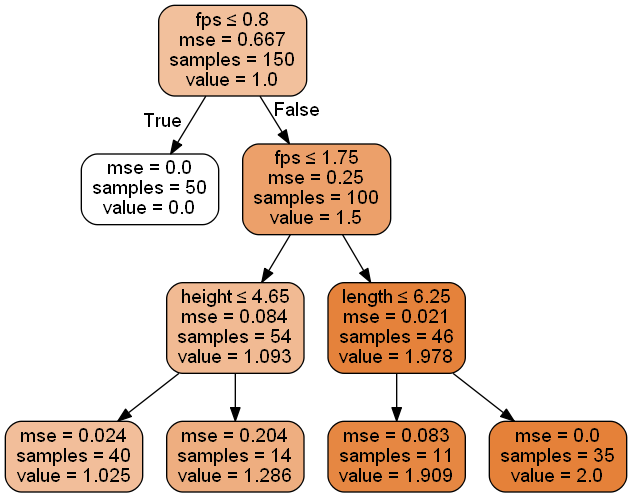

In [14]:
import pandas as pd  
import numpy as np  
import os  

from sklearn import tree  
Dtree = tree.DecisionTreeRegressor(max_depth=3,splitter='best',min_samples_leaf=10,random_state=1111)  
dtree = Dtree.fit(x,y)  
import pydotplus   
from IPython.display import Image  
from six import StringIO
with open("dt.dot", "w") as f:  
    tree.export_graphviz(dtree, out_file=f)  
dot_data = StringIO()  
tree.export_graphviz(dtree, out_file=dot_data,  
                     feature_names=x.columns,  
                     class_names=['bad_ind'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())   
Image(graph.create_png()) 